In [28]:
# cd /jet/home/bermudez
# interact -p GPU-shared --gres=gpu:1 -t 08:00:00 -A cis250242p
# module load AI/pytorch_23.02-1.13.1-py3
# conda activate eeg_env
# jupyter notebook --no-browser --ip=0.0.0.0

In [29]:
# %%
config = {
    'root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589",
    'captions': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt",
    
    'batch_size': 128,
    'num_epochs': 100,
    'model_to_use': "Multiscale", #Multihead|Multiscale
    
    'num_channels':122,
    'num_classes':20,

    'hidden_dim':192,          

    'transformer_dim':256,    
    'n_layers':4,
    'n_heads':4,
    'ff_mult':4,
    'dropout':0.15,

    'lr': 3e-4,
    'weight_decay': 1e-4,
    'label_smoothing': 0.1,
    'max_grad_norm': 1.0,
    
    'results_path': "results/Finetune_Multihead",
}

        

# Imports

In [30]:
# %%
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from torchinfo import summary
import torch.optim as optim
import torch.nn as nn



from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_recall_fscore_support
)

# Add project path
import os
os.chdir('/jet/home/bermudez/exploring-eeg/4-eeg-classifiers')

# ---- Import modules from .py files ----
from data_extraction.dataset_builder import build_trial_index, split_by_session
from data_extraction.dataloader import make_dataloaders, eeg_collate_fn
from models.eeg_net_bl import EEGNetBL
from models.eeg_multihead_transformer import MultiHeadEEGClassifier
from utils.train_utils import (
    train_model, 
    train_multihead_model
)
from utils.eeg_embeddings import export_all_splits_multihead
from utils.eval_results import (
    evaluate_model,
    collect_predictions,
    plot_confusion_matrix,
    compute_per_class_accuracy,
    compute_global_metrics,
    metrics_to_dataframe,
    top_confusion_pairs
)
from models.eeg_multiscale_transformer import MultiScaleEEGTransformerMH



Device: cuda


In [31]:
save_dir = Path(config['results_path'])
save_dir.mkdir(exist_ok=True, parents=True)

# Dataset

In [32]:
# %%
DATASET_ROOT = Path(config['root'])
CAPTIONS_PATH = Path(config['captions'])

index_df = build_trial_index(DATASET_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

print(index_df.head())
print("Total labeled trials:", len(index_df))

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589
Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...   

                                            csv_path  \
0  /ocean/projects/cis250019p

# Dataloader

In [33]:
# %%
loaders = make_dataloaders(index_df,
                           batch_size=config['batch_size'],
                           num_workers=4)

# Inspect one batch
x_batch, y_batch = next(iter(loaders["train"]))
print("Batch EEG shape:", x_batch.shape)
print("Batch labels:", y_batch["class_id"][:10])

train: 15600 samples
val: 5200 samples
test: 5200 samples


Batch EEG shape: torch.Size([128, 500, 122])
Batch labels: tensor([ 3, 12, 10,  7, 13, 17, 17,  4, 10, 15])


# Data Visualization

In [34]:
# %%
def plot_eeg_trial(x, title="EEG Trial", n_channels_to_plot=6, sampling_rate=1000):
    if not isinstance(x, np.ndarray):
        x = x.detach().cpu().numpy()

    # ensure [C, T] shape
    if x.shape[0] > x.shape[1]:
        x = x.T

    num_channels, num_timepoints = x.shape
    time = np.arange(num_timepoints) / sampling_rate
    step = max(1, num_channels // n_channels_to_plot)

    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(range(0, num_channels, step)):
        plt.plot(time, x[ch] + i * 5, lw=0.8)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.tight_layout()
    plt.show()

Subject: sub-19
Session: ses-02
Run: run-03
Category: boat


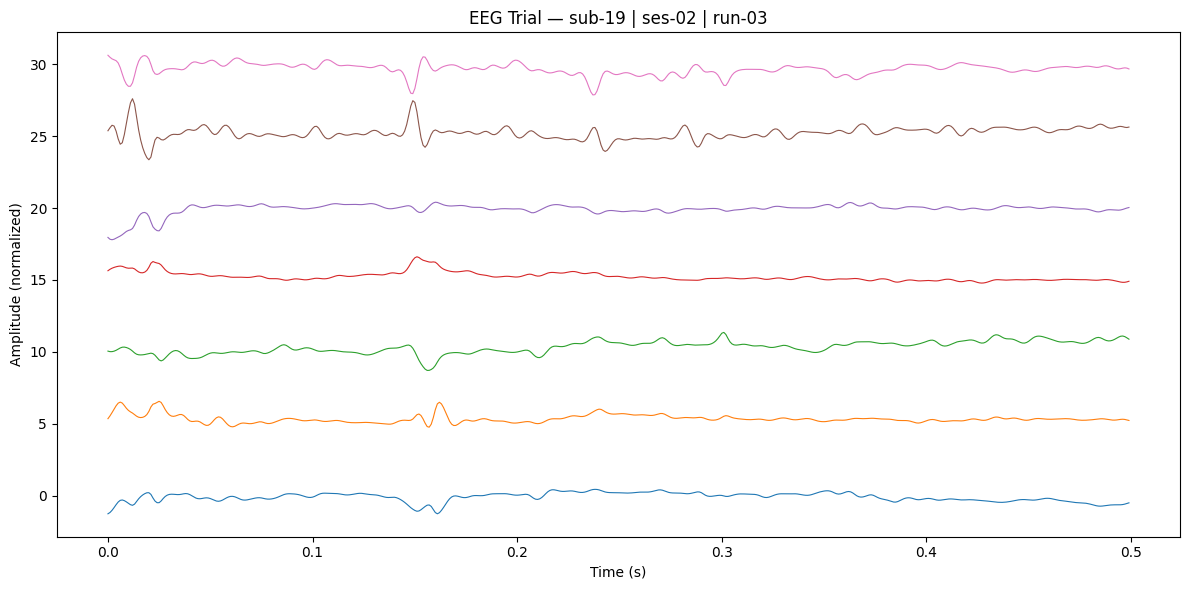

In [35]:
# %%
x_batch, y_batch = next(iter(loaders["train"]))

x_trial = x_batch[0]
meta = {k: v[0] for k, v in y_batch.items() if isinstance(v, list)}

print("Subject:", meta["subject"])
print("Session:", meta["session"])
print("Run:", meta["run"])
print("Category:", meta["category"])

plot_eeg_trial(x_trial, title=f"EEG Trial — {meta['subject']} | {meta['session']} | {meta['run']}")

# Base Line Model

## Setup

In [36]:
# %%
model = EEGNetBL(num_channels=122, num_classes=20).to(device)

print("Model loaded. Parameters:", sum(p.numel() for p in model.parameters()))

summary(
    model,
    input_size=(1, 122, 500),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=1
)

Model loaded. Parameters: 63412
Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --
│    └─AvgPool1d: 2-7          

In [37]:
# %%
EPOCHS = config["num_epochs"]
LR = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

print("Training on:", device)

Training on: cuda


## Training

In [38]:
# %%
history = train_model(
    model=model,
    loaders=loaders,
    device=device,
    epochs=2,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir=Path("checkpoints"),
    max_grad_norm=2.0
)

Epoch 1/2:   0%|                                                                                                                                                                           | 0/122 [00:00<?, ?it/s]

Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 28.95it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch01.pth (val acc=5.35%)
Epoch 01: Train loss=3.0525 | acc=4.95% | Val loss=3.0208 | acc=5.35%


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.56it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch02.pth (val acc=5.52%)
Epoch 02: Train loss=3.0109 | acc=5.63% | Val loss=3.0060 | acc=5.52%
\Training complete. Best epoch 2 with val acc=5.52%


## Evaluation

In [39]:
# Load best model
model.load_state_dict(history["best_state_dict"])
print(f"Loaded best model from epoch {history['best_epoch']} "
      f"with val acc={history['best_val_acc']*100:.2f}%.")

Loaded best model from epoch 2 with val acc=5.52%.


In [40]:
# %%
model.eval()
correct = total = 0

with torch.no_grad():
    for xb, meta in loaders["test"]:
        preds = model(xb.to(device)).argmax(dim=1)
        y = meta["class_id"].to(device)
        correct += (preds == y).sum().item()
        total += len(y)

print(f"Test accuracy: {100 * correct/total:.2f}%")

Test accuracy: 5.27%


In [41]:
# %%
all_preds, all_labels = collect_predictions(model, loaders["test"], device)
print("Collected predictions:", len(all_preds))

Collected predictions: 5200



 Running full evaluation on test set...

Collected 5200 predictions.

 Generating confusion matrix...


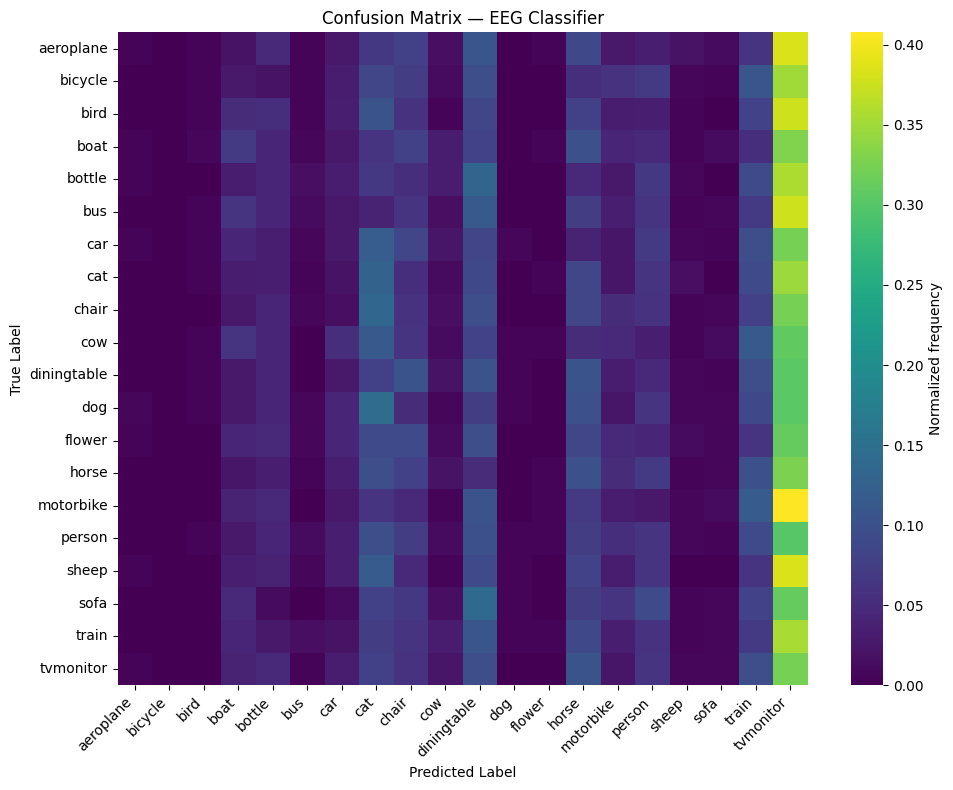


 Computing per-class accuracy...
       Category  Accuracy (%)
19    tvmonitor         32.31
7           cat         12.69
10  diningtable         10.38
13        horse         10.00
18        train          6.92
3          boat          6.92
15       person          6.15
8         chair          5.77
4        bottle          4.23
14    motorbike          3.08
6           car          2.69
5           bus          1.15
9           cow          1.15
17         sofa          0.77
0     aeroplane          0.38
2          bird          0.38
11          dog          0.38
1       bicycle          0.00
12       flower          0.00
16        sheep          0.00

 Computing global metrics...
          Metric  Value (%)
0   Accuracy (%)   5.269231
1  Precision (%)   5.518378
2     Recall (%)   5.269231
3   F1-score (%)   3.747789

 Identifying most common confusion pairs...
        True  Predicted  Count
0  motorbike  tvmonitor    106
1  aeroplane  tvmonitor    100
2      sheep  tvmonitor    1

In [42]:
print("\n Running full evaluation on test set...")
cm, per_class_df, summary_df, confusion_pairs_df = evaluate_model(
    model,
    loaders["test"],
    device=device,
    save_dir="results/"     # saves LaTeX + CSV tables
)

In [43]:
# ===== New Cell: Export evaluation results =====

per_class_df.to_csv("results/per_class_accuracy.csv", index=False)
summary_df.to_csv("results/global_metrics.csv", index=False)
confusion_pairs_df.to_csv("results/top_confusions.csv", index=False)

print("Results exported to results/ folder.")

Results exported to results/ folder.


# Improved Model

## Setup

In [44]:
subjects = sorted(index_df["subject"].unique())
subj2idx = {s: i for i, s in enumerate(subjects)}
print("Subjects + indices:", subj2idx)

Subjects + indices: {'sub-02': 0, 'sub-03': 1, 'sub-05': 2, 'sub-09': 3, 'sub-14': 4, 'sub-15': 5, 'sub-17': 6, 'sub-19': 7, 'sub-20': 8, 'sub-23': 9, 'sub-24': 10, 'sub-28': 11, 'sub-29': 12}


In [45]:
if config['model_to_use'] == "Multihead":
    model_mh = MultiHeadEEGClassifier(
        num_channels = config['num_channels'],
        num_classes = config['num_classes'],
        hidden_dim = config['hidden_dim'],          
        n_layers = config['n_layers'],
        n_heads = config['n_heads'],
        ff_mult = config['ff_mult'],
        dropout = config['dropout']
    )
elif config['model_to_use'] == "Multiscale":
    model_mh = MultiScaleEEGTransformerMH(
        num_channels = config['num_channels'],
        num_classes = config['num_classes'],
        hidden_dim = config['hidden_dim'],          
        transformer_dim = config['transformer_dim'],    
        n_layers = config['n_layers'],
        n_heads = config['n_heads'],
        ff_mult = config['ff_mult'],
        dropout = config['dropout']
    )
model_mh = model_mh.to(device)


num_channels = config['num_channels'],
num_classes = config['num_classes'],
hidden_dim = config['hidden_dim'],          
transformer_dim = config['transformer_dim'],    
n_layers = config['n_layers'],
n_heads = config['n_heads'],
ff_mult = config['ff_mult'],
dropout = config['dropout']

In [46]:
print(f"{config['model_to_use']} model parameters:",
      sum(p.numel() for p in model_mh.parameters() if p.requires_grad))

# Torchinfo summary – we must pass BOTH x and subj_idx as input_data
dummy_x = torch.randn(1, 122, 500).to(device)   # [B, C, T]
dummy_subj = torch.tensor([0], dtype=torch.long).to(device)

summary(
    model_mh,
    input_data=(dummy_x, dummy_subj),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=0
)

Multiscale model parameters: 4953732


Layer (type:depth-idx)                             Kernel Shape              Output Shape              Param #
MultiScaleEEGTransformerMH                         --                        [1, 20]                   --
├─MultiScaleConvBlock: 1-1                         --                        [1, 576, 500]             --
│    └─Conv1d: 2-1                                 [7]                       [1, 192, 500]             164,160
│    └─Conv1d: 2-2                                 [15]                      [1, 192, 500]             351,552
│    └─Conv1d: 2-3                                 [31]                      [1, 192, 500]             726,336
│    └─BatchNorm1d: 2-4                            --                        [1, 576, 500]             1,152
│    └─GELU: 2-5                                   --                        [1, 576, 500]             --
├─DepthwiseSeparableConv: 1-2                      --                        [1, 576, 500]             --
│    └─Conv1d: 2-6     

In [47]:
optimizer = optim.AdamW(
    model_mh.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.98),
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["num_epochs"],
    eta_min=1e-5
)


criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

## Training

In [48]:
history_mh = train_multihead_model(
    model=model_mh,
    loaders=loaders,
    device=device,
    epochs=config["num_epochs"],
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir="checkpoints_multihead",
    max_grad_norm=config['max_grad_norm'],
    subj2idx=subj2idx,
)

[Train] Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 01 | Train loss=3.1139 acc=4.87% | Val loss=3.0870 acc=4.92%
New best model at epoch 1 (val acc=4.92%)


[Train] Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 02 | Train loss=3.0038 acc=7.09% | Val loss=3.0544 acc=5.54%
New best model at epoch 2 (val acc=5.54%)


[Train] Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 03 | Train loss=2.9343 acc=9.59% | Val loss=3.0644 acc=6.38%
New best model at epoch 3 (val acc=6.38%)


[Train] Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.47it/s]


Epoch 04 | Train loss=2.8526 acc=13.45% | Val loss=3.0757 acc=6.50%
New best model at epoch 4 (val acc=6.50%)


[Train] Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 05 | Train loss=2.7472 acc=17.29% | Val loss=3.1646 acc=6.85%
New best model at epoch 5 (val acc=6.85%)


[Train] Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 06 | Train loss=2.6224 acc=22.63% | Val loss=3.2075 acc=6.87%
New best model at epoch 6 (val acc=6.87%)


[Train] Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 07 | Train loss=2.4783 acc=28.12% | Val loss=3.3236 acc=6.90%
New best model at epoch 7 (val acc=6.90%)


[Train] Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 08 | Train loss=2.3183 acc=35.12% | Val loss=3.4412 acc=6.62%


[Train] Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 09 | Train loss=2.1344 acc=42.14% | Val loss=3.6062 acc=7.08%
New best model at epoch 9 (val acc=7.08%)


[Train] Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 10 | Train loss=1.9487 acc=49.86% | Val loss=3.8346 acc=6.35%


[Train] Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 11 | Train loss=1.7569 acc=57.82% | Val loss=4.0663 acc=7.08%


[Train] Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.43it/s]


Epoch 12 | Train loss=1.5843 acc=64.96% | Val loss=4.2892 acc=7.04%


[Train] Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 13 | Train loss=1.4301 acc=71.96% | Val loss=4.4389 acc=7.21%
New best model at epoch 13 (val acc=7.21%)


[Train] Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 14 | Train loss=1.3057 acc=76.98% | Val loss=4.6484 acc=6.83%


[Train] Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 15 | Train loss=1.1910 acc=82.66% | Val loss=4.6412 acc=6.88%


[Train] Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 16 | Train loss=1.0967 acc=86.47% | Val loss=4.8079 acc=6.37%


[Train] Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 17 | Train loss=1.0279 acc=90.14% | Val loss=4.7853 acc=6.90%


[Train] Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 18 | Train loss=0.9767 acc=92.31% | Val loss=4.8382 acc=6.38%


[Train] Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 19 | Train loss=0.9406 acc=93.71% | Val loss=4.8321 acc=6.56%


[Train] Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 20 | Train loss=0.9033 acc=95.22% | Val loss=4.8666 acc=6.71%


[Train] Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 21 | Train loss=0.8753 acc=96.10% | Val loss=4.7945 acc=6.69%


[Train] Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 22 | Train loss=0.8478 acc=96.93% | Val loss=4.6881 acc=6.42%


[Train] Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 23 | Train loss=0.8252 acc=97.56% | Val loss=4.6319 acc=6.73%


[Train] Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 24 | Train loss=0.8103 acc=97.64% | Val loss=4.5938 acc=6.94%


[Train] Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 25 | Train loss=0.7981 acc=97.99% | Val loss=4.5376 acc=6.56%


[Train] Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 26 | Train loss=0.7852 acc=98.13% | Val loss=4.4983 acc=6.67%


[Train] Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 27 | Train loss=0.7687 acc=98.67% | Val loss=4.4274 acc=6.73%


[Train] Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 28 | Train loss=0.7572 acc=98.75% | Val loss=4.3455 acc=6.52%


[Train] Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.43it/s]


Epoch 29 | Train loss=0.7475 acc=98.92% | Val loss=4.2806 acc=6.40%


[Train] Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 30 | Train loss=0.7379 acc=99.03% | Val loss=4.2751 acc=6.58%


[Train] Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.47it/s]


Epoch 31 | Train loss=0.7303 acc=98.99% | Val loss=4.2170 acc=6.69%


[Train] Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 32 | Train loss=0.7217 acc=99.24% | Val loss=4.1854 acc=6.81%


[Train] Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 33 | Train loss=0.7124 acc=99.29% | Val loss=4.1801 acc=6.87%


[Train] Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 34 | Train loss=0.7077 acc=99.28% | Val loss=4.1351 acc=6.90%


[Train] Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 35 | Train loss=0.7020 acc=99.38% | Val loss=4.0812 acc=6.65%


[Train] Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 36 | Train loss=0.6930 acc=99.47% | Val loss=4.0605 acc=6.48%


[Train] Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 37 | Train loss=0.6921 acc=99.37% | Val loss=3.9990 acc=6.81%


[Train] Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 38 | Train loss=0.6867 acc=99.43% | Val loss=3.9724 acc=6.88%


[Train] Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 39 | Train loss=0.6829 acc=99.37% | Val loss=3.9552 acc=7.19%


[Train] Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 40 | Train loss=0.6765 acc=99.56% | Val loss=3.8899 acc=6.96%


[Train] Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.47it/s]


Epoch 41 | Train loss=0.6724 acc=99.56% | Val loss=3.8848 acc=6.98%


[Train] Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 42 | Train loss=0.6689 acc=99.58% | Val loss=3.8774 acc=6.96%


[Train] Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 43 | Train loss=0.6665 acc=99.58% | Val loss=3.8379 acc=7.17%


[Train] Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 44 | Train loss=0.6623 acc=99.60% | Val loss=3.7915 acc=6.48%


[Train] Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 45 | Train loss=0.6595 acc=99.59% | Val loss=3.7852 acc=6.85%


[Train] Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 46 | Train loss=0.6563 acc=99.64% | Val loss=3.7578 acc=6.92%


[Train] Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.47it/s]


Epoch 47 | Train loss=0.6545 acc=99.61% | Val loss=3.7685 acc=6.87%


[Train] Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 48 | Train loss=0.6518 acc=99.61% | Val loss=3.7429 acc=6.60%


[Train] Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 49 | Train loss=0.6498 acc=99.62% | Val loss=3.7157 acc=7.15%


[Train] Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 50 | Train loss=0.6473 acc=99.65% | Val loss=3.7053 acc=6.44%


[Train] Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 51 | Train loss=0.6433 acc=99.70% | Val loss=3.6909 acc=6.60%


[Train] Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 52 | Train loss=0.6418 acc=99.70% | Val loss=3.6701 acc=7.02%


[Train] Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 53 | Train loss=0.6408 acc=99.69% | Val loss=3.6437 acc=7.00%


[Train] Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 54 | Train loss=0.6376 acc=99.78% | Val loss=3.6395 acc=6.69%


[Train] Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 55 | Train loss=0.6361 acc=99.75% | Val loss=3.6245 acc=6.77%


[Train] Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 56 | Train loss=0.6349 acc=99.77% | Val loss=3.6235 acc=6.79%


[Train] Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 57 | Train loss=0.6333 acc=99.77% | Val loss=3.5986 acc=7.00%


[Train] Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 58 | Train loss=0.6311 acc=99.78% | Val loss=3.5894 acc=6.92%


[Train] Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 59 | Train loss=0.6304 acc=99.75% | Val loss=3.5771 acc=6.48%


[Train] Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 60 | Train loss=0.6278 acc=99.79% | Val loss=3.5869 acc=6.73%


[Train] Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 61 | Train loss=0.6273 acc=99.76% | Val loss=3.5527 acc=6.60%


[Train] Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 62 | Train loss=0.6255 acc=99.80% | Val loss=3.5457 acc=6.77%


[Train] Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 63 | Train loss=0.6249 acc=99.79% | Val loss=3.5436 acc=7.04%


[Train] Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 64 | Train loss=0.6231 acc=99.79% | Val loss=3.5347 acc=7.13%


[Train] Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.43it/s]


Epoch 65 | Train loss=0.6226 acc=99.80% | Val loss=3.5231 acc=6.71%


[Train] Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.39it/s]


Epoch 66 | Train loss=0.6210 acc=99.81% | Val loss=3.5212 acc=6.52%


[Train] Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 67 | Train loss=0.6204 acc=99.81% | Val loss=3.4969 acc=6.92%


[Train] Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 68 | Train loss=0.6195 acc=99.80% | Val loss=3.5036 acc=7.06%


[Train] Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 69 | Train loss=0.6186 acc=99.82% | Val loss=3.4981 acc=7.48%
New best model at epoch 69 (val acc=7.48%)


[Train] Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 70 | Train loss=0.6176 acc=99.83% | Val loss=3.4963 acc=7.12%


[Train] Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 71 | Train loss=0.6174 acc=99.81% | Val loss=3.4874 acc=7.15%


[Train] Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 72 | Train loss=0.6161 acc=99.81% | Val loss=3.4811 acc=7.31%


[Train] Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 73 | Train loss=0.6154 acc=99.83% | Val loss=3.4804 acc=7.12%


[Train] Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 74 | Train loss=0.6152 acc=99.83% | Val loss=3.4772 acc=6.85%


[Train] Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 75 | Train loss=0.6141 acc=99.88% | Val loss=3.4732 acc=7.15%


[Train] Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 76 | Train loss=0.6139 acc=99.85% | Val loss=3.4608 acc=6.94%


[Train] Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 77 | Train loss=0.6132 acc=99.82% | Val loss=3.4667 acc=7.17%


[Train] Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.47it/s]


Epoch 78 | Train loss=0.6127 acc=99.85% | Val loss=3.4589 acc=7.04%


[Train] Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 79 | Train loss=0.6123 acc=99.83% | Val loss=3.4576 acc=7.06%


[Train] Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 80 | Train loss=0.6115 acc=99.85% | Val loss=3.4548 acc=7.21%


[Train] Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 81 | Train loss=0.6113 acc=99.86% | Val loss=3.4516 acc=7.38%


[Train] Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 82 | Train loss=0.6109 acc=99.86% | Val loss=3.4469 acc=7.40%


[Train] Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 83 | Train loss=0.6102 acc=99.88% | Val loss=3.4443 acc=7.23%


[Train] Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 84 | Train loss=0.6101 acc=99.87% | Val loss=3.4480 acc=7.06%


[Train] Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 85 | Train loss=0.6098 acc=99.86% | Val loss=3.4440 acc=7.23%


[Train] Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 86 | Train loss=0.6093 acc=99.88% | Val loss=3.4413 acc=6.94%


[Train] Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 87 | Train loss=0.6092 acc=99.88% | Val loss=3.4403 acc=7.02%


[Train] Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 88 | Train loss=0.6088 acc=99.88% | Val loss=3.4397 acc=7.08%


[Train] Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 89 | Train loss=0.6087 acc=99.91% | Val loss=3.4367 acc=6.94%


[Train] Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 90 | Train loss=0.6082 acc=99.89% | Val loss=3.4331 acc=7.25%


[Train] Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.46it/s]


Epoch 91 | Train loss=0.6080 acc=99.90% | Val loss=3.4356 acc=7.02%


[Train] Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 92 | Train loss=0.6079 acc=99.88% | Val loss=3.4319 acc=7.12%


[Train] Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 93 | Train loss=0.6079 acc=99.89% | Val loss=3.4297 acc=7.02%


[Train] Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.45it/s]


Epoch 94 | Train loss=0.6075 acc=99.90% | Val loss=3.4311 acc=7.19%


[Train] Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 95 | Train loss=0.6074 acc=99.91% | Val loss=3.4299 acc=7.12%


[Train] Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 96 | Train loss=0.6071 acc=99.90% | Val loss=3.4270 acc=7.02%


[Train] Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 97 | Train loss=0.6072 acc=99.92% | Val loss=3.4294 acc=7.04%


[Train] Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 98 | Train loss=0.6070 acc=99.93% | Val loss=3.4271 acc=6.85%


[Train] Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 99 | Train loss=0.6071 acc=99.90% | Val loss=3.4282 acc=6.92%


[Train] Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:35<00:00,  3.44it/s]


Epoch 100 | Train loss=0.6071 acc=99.88% | Val loss=3.4287 acc=7.13%

Training complete. Best epoch=69 val acc=7.48%


## Evaluation

In [49]:
model_mh.load_state_dict(history_mh["best_state_dict"])
print(f"Loaded best multi-head model from epoch {history_mh['best_epoch']} "
      f"(val acc={history_mh['best_val_acc']*100:.2f}%).")

Loaded best multi-head model from epoch 69 (val acc=7.48%).


In [50]:
# %%
def collect_predictions_multihead(model, loader, device, subj2idx):
    """
    Run model over a loader and collect predictions + labels for multi-head model.
    model(x, subj_idx) -> logits
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, meta in tqdm(loader, desc="Evaluating (multi-head)"):
            x = xb.to(device)
            y = meta["class_id"].to(device)

            subj_idx = torch.tensor(
                [subj2idx[s] for s in meta["subject"]],
                dtype=torch.long,
                device=device,
            )

            logits = model(x, subj_idx)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_preds, all_labels

# Collect predictions on test set
mh_preds, mh_labels = collect_predictions_multihead(
    model_mh, loaders["test"], device, subj2idx
)
print("Collected multi-head predictions:", len(mh_preds))

Evaluating (multi-head): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 12.39it/s]


Collected multi-head predictions: 5200


In [51]:
# %%
test_acc_mh = accuracy_score(mh_labels, mh_preds)
print(f"Multi-head Test Accuracy: {test_acc_mh*100:.2f}%")

Multi-head Test Accuracy: 7.15%


Confusion matrix saved at results/Finetune_Multihead/confusion_matrix.png


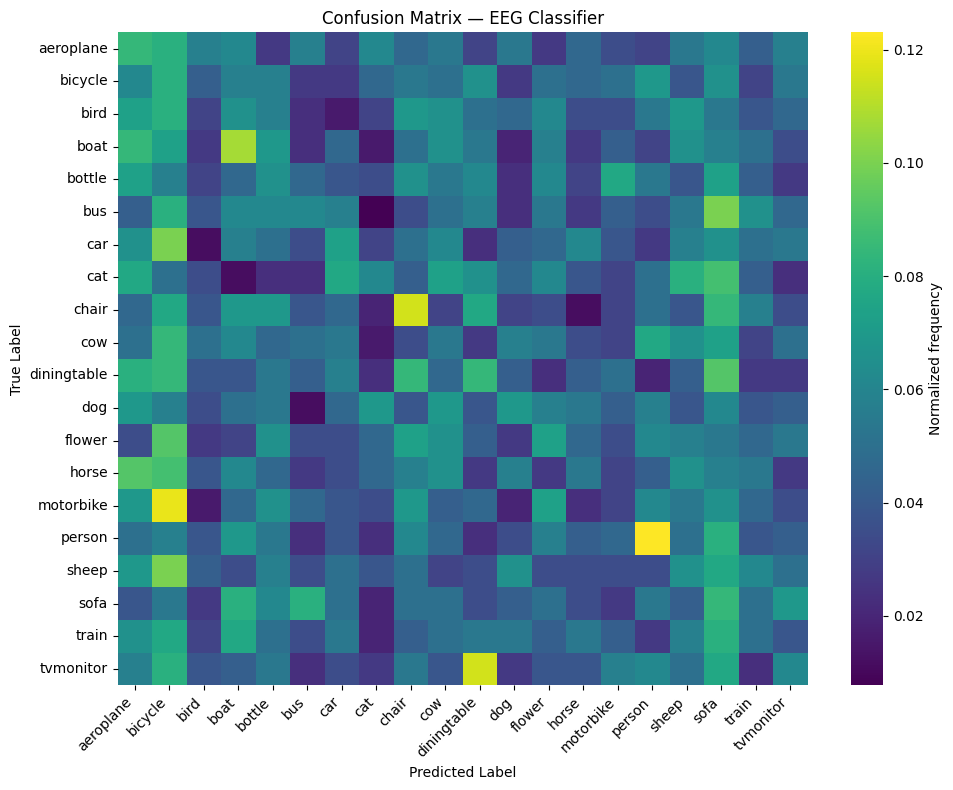

     Category  Accuracy (%)
15     person         12.31
8       chair         11.54
3        boat         10.77
0   aeroplane          8.46
17       sofa          8.46
          Metric  Value (%)
0   Accuracy (%)   7.153846
1  Precision (%)   7.205861
2     Recall (%)   7.153846
3   F1-score (%)   7.095896
[('motorbike', 'bicycle', np.int64(31)), ('tvmonitor', 'diningtable', np.int64(30)), ('bus', 'sofa', np.int64(26)), ('car', 'bicycle', np.int64(26)), ('sheep', 'bicycle', np.int64(26)), ('diningtable', 'sofa', np.int64(24)), ('flower', 'bicycle', np.int64(24)), ('horse', 'aeroplane', np.int64(24)), ('cat', 'sofa', np.int64(23)), ('horse', 'bicycle', np.int64(23))]


In [52]:
# Confusion matrix
cm_mh = plot_confusion_matrix(
    mh_labels,
    mh_preds,
    normalize=True,
    save_path=f"{config['results_path']}/confusion_matrix.png"
)

# Per-class accuracy
per_class_df_mh = compute_per_class_accuracy(mh_labels, mh_preds)
print(per_class_df_mh.head())

# Global metrics
metrics_dict_mh = compute_global_metrics(mh_labels, mh_preds)
summary_df_mh = metrics_to_dataframe(metrics_dict_mh)
print(summary_df_mh)

# Top confusing pairs
confusion_pairs_df_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)
print(confusion_pairs_df_mh)

In [53]:
per_class_df_mh.to_csv(save_dir / "per_class_accuracy.csv", index=False)
summary_df_mh.to_csv(save_dir / "global_metrics.csv", index=False)
# Top confusion pairs (list of tuples)
confusion_pairs_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)

# Convert to DataFrame
confusion_pairs_df_mh = pd.DataFrame(
    confusion_pairs_mh,
    columns=["True Label", "Predicted Label", "Count"]
)

print(confusion_pairs_df_mh)

# Save
confusion_pairs_df_mh.to_csv(save_dir / "top_confusions.csv", index=False)

with open(save_dir / "per_class_accuracy.tex", "w") as f:
    f.write(per_class_df_mh.to_latex(index=False, float_format="%.2f"))

with open(save_dir / "global_metrics.tex", "w") as f:
    f.write(summary_df_mh.to_latex(index=False, float_format="%.2f"))

print("Multi-head evaluation tables saved in results_multihead/")

    True Label Predicted Label  Count
0    motorbike         bicycle     31
1    tvmonitor     diningtable     30
2          bus            sofa     26
3          car         bicycle     26
4        sheep         bicycle     26
5  diningtable            sofa     24
6       flower         bicycle     24
7        horse       aeroplane     24
8          cat            sofa     23
9        horse         bicycle     23
Multi-head evaluation tables saved in results_multihead/


# Implement best model for CLIP layer

In [54]:
# Make sure best weights from training are loaded
model_mh.load_state_dict(history_mh["best_state_dict"])
model_mh.eval()
model_mh.to(device)

export_all_splits_multihead(
    model_mh, loaders, device, subj2idx,
    save_dir=config['results_path']
)

print("\nEEG embeddings saved in:", config['results_path'])


=== Exporting split: train ===


Collected 15600 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_train_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_train_meta.csv
Shape: embeddings=(15600, 256), rows=15600

=== Exporting split: val ===
Collected 5200 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_val_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_val_meta.csv
Shape: embeddings=(5200, 256), rows=5200

=== Exporting split: test ===
Collected 5200 embeddings, dim=256
Saved embeddings to: results/Finetune_Multihead/multihead_test_embeddings.npy
Saved metadata  to: results/Finetune_Multihead/multihead_test_meta.csv
Shape: embeddings=(5200, 256), rows=5200

EEG embeddings saved in: results/Finetune_Multihead
